In [1]:
#要降版本, 不然程式會有問題
%tensorflow_version 1.x
import tensorflow as tf

tf.__version__

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
#Generator
def build_generator(img_shape, z_dim):
    model = Sequential()
    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))
    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))
    return model

#Discriminator
def build_discriminator(img_shape):
    model = Sequential()
    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))
    # Fully connected layer
    model.add(Dense(128))
    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    return model

#Build the Model
def build_gan(generator, discriminator):
    model = Sequential()
    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)
    return model

# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
          optimizer=Adam(),
          metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
#Training
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()
    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    # Labels for real images: all ones
    real = np.ones((batch_size, 1))
    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    # Generate images from random noise
    gen_imgs = generator.predict(z)
    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5
    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                  image_grid_columns,
                  figsize=(4, 4),
                  sharey=True,
                  sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

11493376/11490434 [==============================] - 0s 0us/step



/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.058452, acc.: 99.22%] [G loss: 3.716392]
2000 [D loss: 0.115886, acc.: 96.09%] [G loss: 5.296096]
3000 [D loss: 0.064490, acc.: 96.88%] [G loss: 6.841950]
4000 [D loss: 0.092279, acc.: 97.66%] [G loss: 5.208299]
5000 [D loss: 0.287939, acc.: 88.67%] [G loss: 4.327495]
6000 [D loss: 0.359760, acc.: 82.81%] [G loss: 2.951684]
7000 [D loss: 0.223118, acc.: 91.41%] [G loss: 4.887624]
8000 [D loss: 0.377190, acc.: 81.64%] [G loss: 3.237534]
9000 [D loss: 0.261287, acc.: 89.06%] [G loss: 4.370337]
10000 [D loss: 0.600082, acc.: 75.39%] [G loss: 3.105331]
11000 [D loss: 0.220138, acc.: 91.80%] [G loss: 4.221866]
12000 [D loss: 0.371846, acc.: 83.98%] [G loss: 3.254084]
13000 [D loss: 0.327562, acc.: 85.94%] [G loss: 3.369433]
14000 [D loss: 0.479140, acc.: 79.69%] [G loss: 2.661975]
15000 [D loss: 0.241597, acc.: 91.02%] [G loss: 3.341811]
16000 [D loss: 0.304194, acc.: 88.28%] [G loss: 3.333225]
17000 [D loss: 0.326392, acc.: 86.72%] [G loss: 2.744120]
18000 [D loss: 0.393696

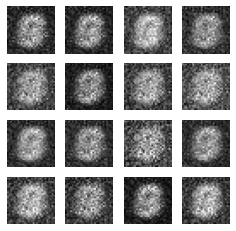

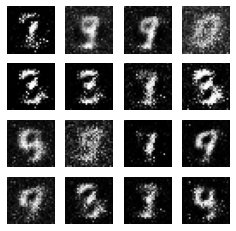

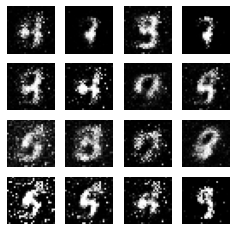

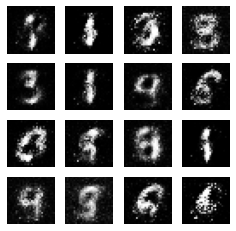

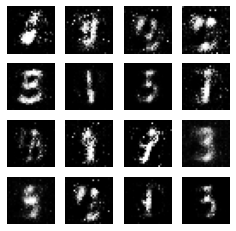

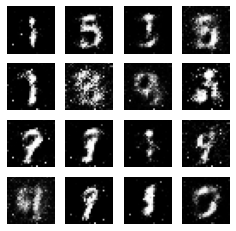

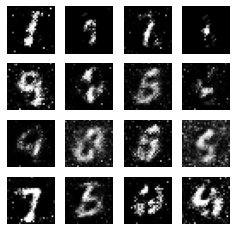

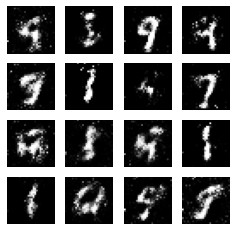

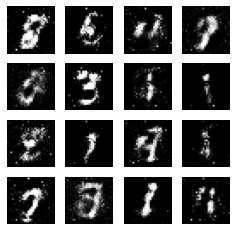

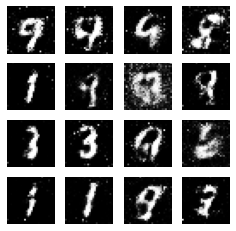

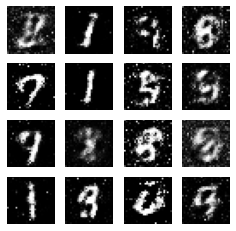

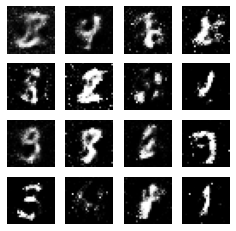

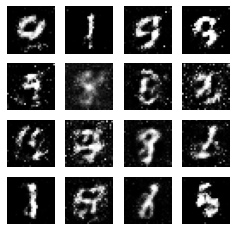

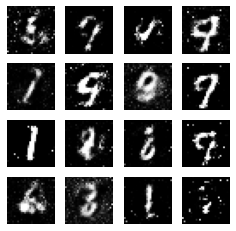

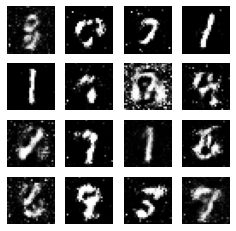

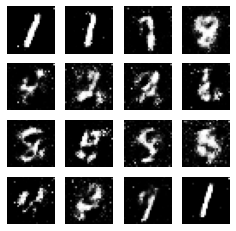

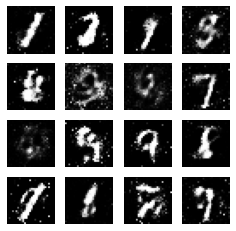

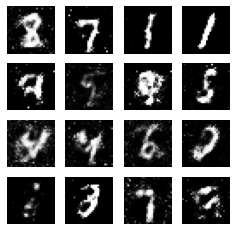

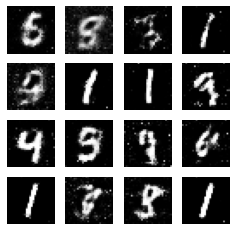

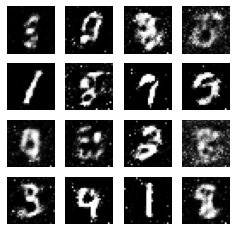

In [4]:
#Train the GAN and Inspect Output
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

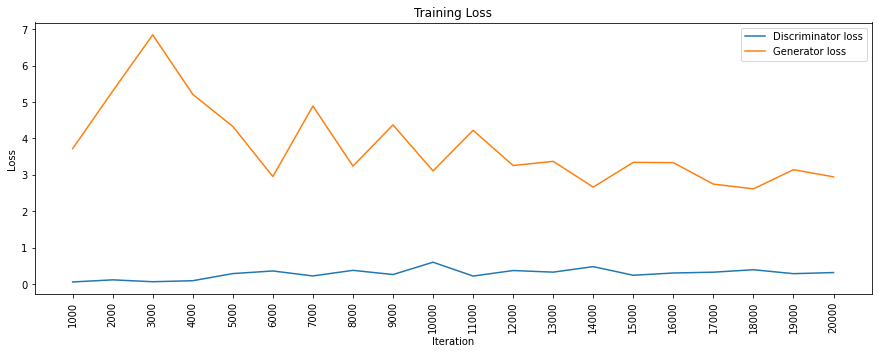

In [5]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

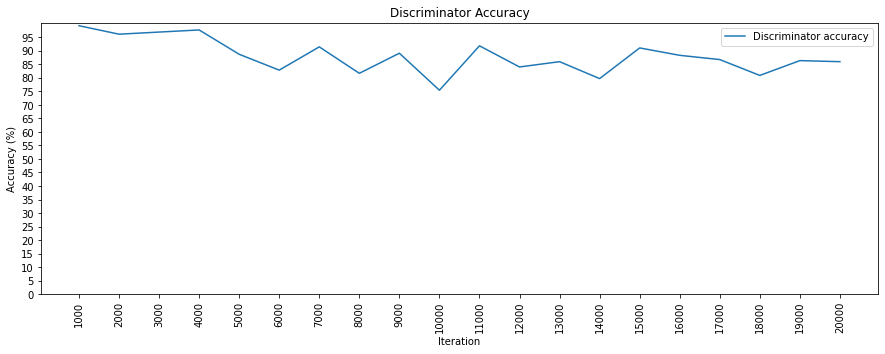

In [6]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()